# Assignment 1

MANJYOT SINGH NANRA <br>
21111038 <br>
manjyots21@iitk.ac.in

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import random as rnd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

plt.style.use('fivethirtyeight')
from copy import deepcopy

In [2]:
# from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [3]:
# v0 = 1
# tau = 10*ms
# eqs = '''
# dv/dt = (v0-v)/tau : 1
# '''

In [4]:
# G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
# M = StateMonitor(G, 'v', record=True)
# spikemon = SpikeMonitor(G)

In [5]:
# run(100*ms)
# plot(M.t/ms, M.v[0])
# xlabel('Time (ms)')
# ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

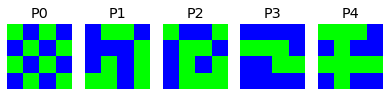

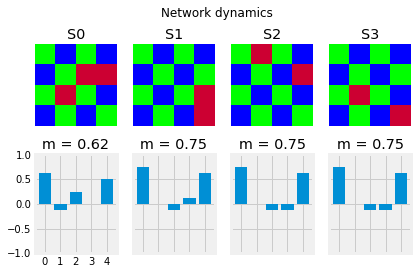

In [6]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=3)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

## Assignment 1

## Question 1
Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)



Writing my own Hopfield Network model using the skeleton provided. After seeing the skeleton code, it becomes obvious that we need to complete few functions

#### Function 1: get_patterns(pattern_size, number_of_patterns):
This function will generate pattern list whose values will contain -1 or 1 randomly. It will contain square arrays of size pattern_size*pattern_size and count will be "number_of_patterns" 

In [7]:
def generate_random_pattern(pattern_size):
    # generates a pattern matrix with random elements.
    
    matrix = []
    for i in range(pattern_size):
        row = []
        for j in range(pattern_size):
            # Appends a random choice of -1 or 1 to the row
            row.append(rnd.choice([-1,1]))
        
        matrix.append(row)
    return matrix

def get_patterns(pattern_size, number_of_pattern):
    # generates list of patterns

    patterns = []
    
    for i in range(number_of_pattern):
        patterns.append(generate_random_pattern(pattern_size))

    return np.array(patterns)

#### Function 2: perturb_pattern(pattern, number_of_flips):
This function is used to make flips at random position in a pattern. 
We perform perturb in pattern to distort informativeness of the cue. 
Then later we will check how well does the hopfield network behaves

In [8]:
def perturb_pattern(pattern, number_of_flips):
    # Perform flips in a given pattern

    # Obtaining number of rows and columns for the pattern.
    columns = len(pattern[0])
    rows = len(pattern)

    # using lookup set to store already flipped bits so that a bit isn't flipped more than once. 
    lookup_set = set()
    i = 0
    while i!=number_of_flips:
        row_val = rnd.choice(range(rows))
        col_val = rnd.choice(range(columns))

        # checking if a bit has already been flipped. if yes skip.
        if f"{row_val}-{col_val}" in lookup_set:
            continue

        else:
            # flip the bit
            if pattern[row_val][col_val] == -1:
                pattern[row_val][col_val] = 1
            else:
                pattern[row_val][col_val] = -1
            i += 1
            lookup_set.add(f"{row_val}-{col_val}")
    return pattern

            


#### Function 3: calculate_weights(pattern_list, pattern_size):
Formula for calculating weight matrix: $$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$
We can see that for getting $w_{ij}$ we take summation over all pattern.

This function will calculate the above matrix in iterative manner. <br>
Since using for loops is slower, I have also made another function calculate_weights_vectorized to speed up the process

In [9]:
def update_weights(pattern, weights, pattern_size,weight_size):
    # Helper Function for calculating the weights
    # This function takes a single pattern and weights matrix
    # It uses this single pattern to update weights.

    for i in range(weight_size):
        for j in range(weight_size):

            if i == j:
                # Diagonal elements are 0, so skip
                continue

            if i > j:
                # Weights are symmetric
                weights[i][j] = weights[j][i]
            
            else:
                row_val_i = int(math.floor(i/pattern_size))
                col_val_i = int(i%pattern_size)
                row_val_j = int(math.floor(j/pattern_size))
                col_val_j = int(j%pattern_size)
                weights[i][j] += pattern[row_val_i][col_val_i] * pattern[row_val_j][col_val_j]
    

def calculate_weights(pattern_list, pattern_size):
    # Naive Implementation of calculating weights 
    # This function will call update weights for calculating weights

    weight_size = pattern_size**2
    weights = [[ 0 for i in range(weight_size) ] for j in range(weight_size) ]
    
    for i in range(len(pattern_list)):
        
        # calling update weights function and passing it single pattern
        update_weights(pattern_list[i], weights, pattern_size, weight_size)
    
    for i in range(weight_size):
        # Dividing the weights by weight_size
        for j in range(weight_size):
            weights[i][j] /= weight_size

    return weights

def calculate_weights_vectorized(pattern_list, pattern_size):
    # Simple vectorized implementation of calculating weights
    # This function uses matrix multiplication to compute weight matrix
    # using numpy library for matrix multiplication speeds up the process
    
    pattern_list = np.array(pattern_list)
    weight_size = pattern_size**2
    weights = np.zeros((weight_size, weight_size))
    
    # Reshaping list of pattern matrix to list of 1d pattern arrays 
    pattern_1d = pattern_list.reshape(len(pattern_list),-1)

    # Matrix multiplication.
    weights = np.matmul(pattern_1d.T, pattern_1d)

    # diagonal elements are 0s, so filling it with 0.
    np.fill_diagonal(weights,0)
    return weights/weight_size

#### Function 4: network_evolution(init_state, weights):
This function performs the following task:  
$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right) $$

Given a state_input and weights, we need to compute the next state using the formula. <br>
This is done in two different functions, one is a naive implementation and one is optimized using vectorization properties.<br>
For main code, I am using vectorized implementation.

In [10]:
def network_evolution(init_state, weights):
    # Naive implementation of network_evolution

    # Getting number of neurons and pattern size
    no_of_neurons = len(weights)
    pattern_size = len(init_state)
    # Generating next_state list
    next_state = [[ 0 for i in range(pattern_size) ] for j in range(pattern_size) ]

    for i in range(no_of_neurons):
        # Calculating for every neuron

        row_val_i = int(math.floor(i/pattern_size))
        col_val_i = int(i%pattern_size)
        for j in range(no_of_neurons):
            row_val = int(math.floor(j/pattern_size))
            col_val = int(j%pattern_size)
            next_state[row_val_i][col_val_i] += weights[i][j] * init_state[row_val][col_val]  

    # Replacing numbers with -1 or 1 depending on whether they are positive or negative
    for i in range(pattern_size):
        for j in range(pattern_size):
            if next_state[i][j] > 0:
                next_state[i][j] = 1
            else:
                next_state[i][j] = -1
    return np.array(next_state)

def network_evolution_optimized(init_state, weights):
    # Optimized implementation because naive implementation was slower
    # Used np.multiply function to calculate the next state 

    pattern_size = len(init_state)

    # multiplication of weights and state to get the next_state matrix 
    next_state = np.multiply(weights, init_state.flatten())

    # Summation of the matrix to get final next_state
    next_state = np.sum(next_state, axis=1)

    # Converting 1d next_state array to proper matrix representation
    next_state = next_state.reshape(pattern_size, pattern_size)

    # Replacing numbers with -1 or 1 depending on whether they are positive or negative
    next_state[next_state<=0]  = -1
    next_state[next_state>0] = 1
    
    return np.array(next_state)
    

Using the above functions to define function for hopfield network.<br>


In [11]:
def hopfield_network(number_of_perturbs=3, number_of_patterns=5, pattern_size=4,plot_output=False):
    # main function of hopfield network

    # Getting the pattern list
    plist = get_patterns(pattern_size,number_of_patterns)

    # Getting a copy of plist
    cue = deepcopy(plist)

    # Grabbing the first element of state and performing perturbs on it
    S = perturb_pattern(cue[0],number_of_perturbs)

    # Calculating weights, by using plist to train the model
    wghts = calculate_weights_vectorized(plist, pattern_size)

    # Preparing state_list this list will store all the states after network evolution 
    state_list =[S]
    
    for i in range(4):
        # Performing network evolution and storing updated list
        state_list.append(network_evolution_optimized(S,wghts))
        
        S = state_list[-1]

    # Plotting the output if required
    if plot_output:
        plot_tools.plot_pattern_list(plist) # plotting the initial pattern list
        plot_tools.plot_pattern(state_list[0]) # Plotting the perturbed pattern

        # Plotting the evolution of state_list and its overlap
        plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics") 

    # Returning the overlap value of the final state with its original patttern
    overlap_val = pattern_tools.compute_overlap(state_list[-1], plist[0])
    
    return overlap_val

Now we will run the above function using following parameters
- number of perturbs = 3
- number of patterns = 5 
- pattern size = 4

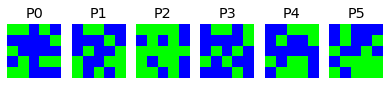

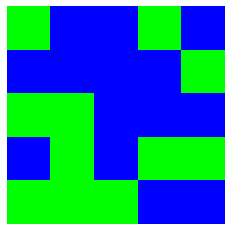

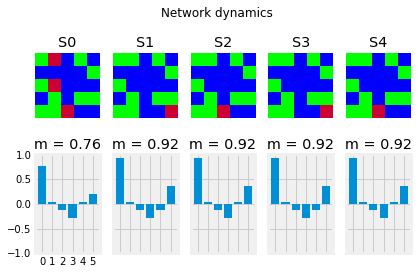

0.92

In [12]:

hopfield_network(number_of_perturbs=3,number_of_patterns=6,pattern_size=5,plot_output=True)
#weights, S, state_list = hopfield_network(number_of_perturbs=3,number_of_patterns=5,pattern_size=4,plot_output=True, debug= True)

## Question 2
Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

INFORMATIVENESS OF CUE

Informativeness of cue, meaning perturbing the pattern. 
We will see how is the model capacity detoriates by visualizing through graphs

Plotting over perturb range of 1 to 100 for different pattern sizes

Note that the "m" value we get is cosine similarity

In [13]:
perturbs = range(1,63)
pattern_size1 = 8
pattern_size2 = 9
pattern_size3 = 10
number_of_patterns = 10

output1 = []
output2 = []
output3 = []

for perturn_no in perturbs:
    output1.append(hopfield_network(perturn_no, number_of_patterns, pattern_size1))
    output2.append(hopfield_network(perturn_no, number_of_patterns, pattern_size2))
    output3.append(hopfield_network(perturn_no, number_of_patterns, pattern_size3))

[]

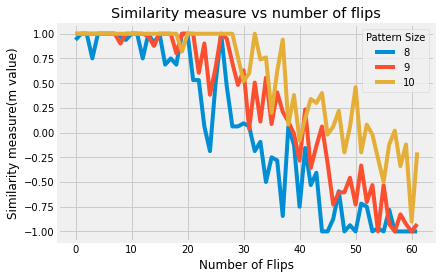

In [14]:
plt.plot(output1)
plt.plot(output2)
plt.plot(output3)
plt.legend(["8","9","10"], title="Pattern Size")
plt.xlabel("Number of Flips")
plt.ylabel("Similarity measure(m value)")
plt.title("Similarity measure vs number of flips")
plt.plot()

Thus we can see that there is a downwards trend in the similarity measure on increasing number of flips. This means that if informativeness of cue deteriorate too much, Models capacity to retrieve the pattern worsens. This means Hopfield Network will behave poorly on decreasing informativeness of the cue and will get better if cues informativeness is not decreased. 

NUMBER OF PATTERNS

Checking models capacity upon number of patterns

In [15]:
pattern_number_list = range(3,100)
pattern_size1 = 8
pattern_size2 = 9
pattern_size3 = 10

number_of_perturbs = 15
output1 = []
output2 = []
output3 = []
for number_of_patterns in pattern_number_list:
    output1.append(hopfield_network(number_of_perturbs, number_of_patterns, pattern_size1))
    output2.append(hopfield_network(number_of_perturbs, number_of_patterns, pattern_size2))
    output3.append(hopfield_network(number_of_perturbs, number_of_patterns, pattern_size3))



[]

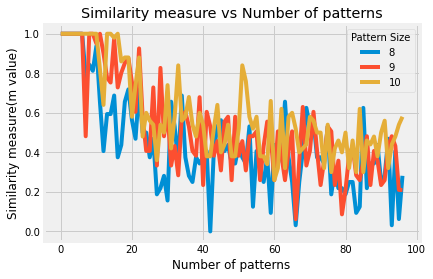

In [16]:
plt.plot(output1)
plt.plot(output2)
plt.plot(output3)

plt.legend(["8","9","10"], title="Pattern Size")
plt.xlabel("Number of patterns")
plt.ylabel("Similarity measure(m value)")
plt.title("Similarity measure vs Number of patterns")
plt.plot()


As we can see, theres not so obvious but a downwards trend when we increase number of patterns, where Networks quality to retain information is deteriorating on increasing number of patterns. A possible reason for this could be related to the amount of information hopfield pattern can store is finite and limited. So if we feed it more number of patters, quality will deteriorate. Probablity of error [REF](https://www.doc.ic.ac.uk/~ae/papers/Hopfield-networks-15.pdf)

PATTERN SIZE

We will now run the code over various pattern sizes and see the performance of network. We will keep number of perturbs fixed to 15 and number of patters 20

In [17]:
number_of_patterns = 20
pattern_size_list = range(4,20)
number_of_perturbs = 15
output = []
for pattern_size in pattern_size_list:
    output.append(hopfield_network(number_of_perturbs, number_of_patterns, pattern_size))

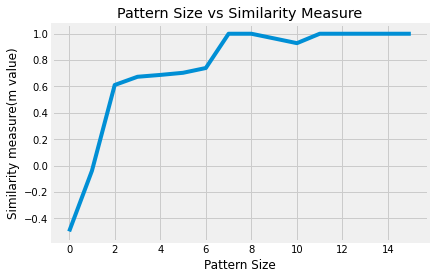

In [18]:
plt.title("Pattern Size vs Similarity Measure")
plt.xlabel("Pattern Size")
plt.ylabel("Similarity measure(m value)")
plt.plot(output)

We can see that performance of model increasing by increasing the pattern size. This is because higher the pattern size, more will be the nodes in network thus size of network will increase enabling it to store more data. 

## Question 3 
Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

In [19]:
# Importing the mnist dataset and required libraries
import mnist
from PIL import Image

In [20]:
# Loading the training set and test set images and labels
training_images = mnist.train_images()
training_label = mnist.train_labels()

test_images = mnist.test_images()
test_label = mnist.test_labels()

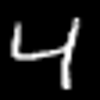

In [21]:
# Visualizing a image from dataset
Image.fromarray(training_images[2]).resize((100,100))


In [22]:
print("Training Data Dimensions:",training_images.shape)
print("Test Data Dimensions:",test_images.shape)

Training Data Dimensions: (60000, 28, 28)
Test Data Dimensions: (10000, 28, 28)


As we can see that training set contains 60000 images and test set contains 10000 images. Images are of dimension 28*28.<br>
Also images are stored as pixel intensity ranging from 0 to 255. <br>
We need to convert this data to our desired Hopfield friendly pattern. For this we will have a threshold of 127. <br>
For pixel intensity less than 127, we will set it to -1 and pixel intensity greater than 127 will be set to 1.<br>
Doing this will make our image dataset correspond to the hopfield dataset

In [23]:
def perform_thresholding(training_images, threshold=127, pattern_size = 28):
    training_conv = np.zeros((len(training_images),pattern_size,pattern_size))
    for i in range(len(training_images)):
        threshold = 127
        img_boolean = (training_images[i]>=threshold) # This will return array of true and false

        # converting boolean to int
        img_int = img_boolean.astype(int) # https://stackoverflow.com/questions/17506163/how-to-convert-a-boolean-array-to-an-int-array
        img_int[img_int == 0] = -1 # Setting 0's to -1

        training_conv[i,:,:] = img_int

    return training_conv
    

In [24]:
# Converting both training set and test set to hopfield suitable patterns
training_conv = perform_thresholding(training_images)
test_conv = perform_thresholding(test_images)
# weights = calculate_weights_vectorized(training_conv[:60000,:,:], 28)

Visualizing the converted number by plotting the pattern

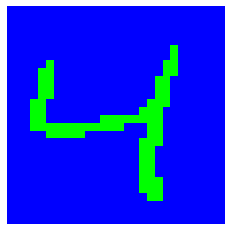

In [25]:
plot_tools.plot_pattern(training_conv[2])

Thus, MNIST dataset has been succesfully converted to the sort of patterns used in Hopfield network

## Question 4
Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

We have already converted MNIST data to desired patterns. Now next step is to train the weights using the training data 

In [26]:
weights = calculate_weights_vectorized(training_conv, 28)

In [27]:
# Visualizing weights
weights

array([[ 0.        , 76.53061224, 76.53061224, ..., 76.53061224,
        76.53061224, 76.53061224],
       [76.53061224,  0.        , 76.53061224, ..., 76.53061224,
        76.53061224, 76.53061224],
       [76.53061224, 76.53061224,  0.        , ..., 76.53061224,
        76.53061224, 76.53061224],
       ...,
       [76.53061224, 76.53061224, 76.53061224, ...,  0.        ,
        76.53061224, 76.53061224],
       [76.53061224, 76.53061224, 76.53061224, ..., 76.53061224,
         0.        , 76.53061224],
       [76.53061224, 76.53061224, 76.53061224, ..., 76.53061224,
        76.53061224,  0.        ]])

In [28]:
# Weight shape
weights.shape

(784, 784)

In [29]:
# For calculating the overlap, we will not do it with every training example.
# Instead we will have one representative per image.
idx= np.unique(training_label, return_index=True)[1]
state_comparison_list = training_images[idx] 
state_comparison_label = training_label[idx]

Now we have our training data, and weights trained, also we have a comparison list over which we will calculate overlap.<br>
Now we perform network evolution on test set images.<br>


In [30]:
def MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv, weights, number_of_evolutions=1,plot_final_state=False):
    output = []
    for test_image in test_conv:
        S = test_image
        state_list = [test_image]

        for i in range(number_of_evolutions):

            state_list.append(network_evolution_optimized(S,weights))
            S = state_list[-1]
        op = pattern_tools.compute_overlap_list(state_list[-1], state_comparison_list)
        output.append(state_comparison_label[op.argmax()])
        if plot_final_state:
            plot_tools.plot_pattern(state_list[-1])
    return output


In [31]:
output = MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv[:200,:,:], weights, 1,False)

Finding out the accuracy score and F1 Score for this model.

In [32]:
print("Accuracy is ",accuracy_score(output, test_label[0:200]))
print("F1 Score is ",f1_score(test_label[0:200], output,average="weighted"))

Accuracy is  0.16
F1 Score is  0.05668422161365072


We can see that our model is behaving poorly. Now we will analyse what is going wrong. 

Lets visualize how our trained weights and images look like

In [33]:
dummy_image = training_conv[2]
print("Total pixels in image = ", len(dummy_image.flatten()))
print("Total Positive Pixels = ", np.sum(dummy_image > 0))
print("Total Negative Pixels = ", np.sum(dummy_image < 0))

Total pixels in image =  784
Total Positive Pixels =  81
Total Negative Pixels =  703


In [34]:
weights_unique, weight_counts = np.unique(weights, return_counts=True)
print("Total neurons in weights = ", np.sum(weight_counts))
print("Total number of Positive weights = ", np.sum(weight_counts[weights_unique<0]))
print("Total number of Negative weights = ", np.sum(weight_counts[weights_unique>0]))

Total neurons in weights =  614656
Total number of Positive weights =  38164
Total number of Negative weights =  575702


Thus we can see that majority of the pixels in the images are negative, and since weight formula is $w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu} $, this causes most of the weights to be positive(-1*-1 = 1) and summation causes it to become big positive numbers. <br>
And once the weights are positive, and most of the test input pixels will be -1, so (1 * -1 = -1) thus most pixels in the state evolution ends up being -1 and only where more of (+1) pixels are concentrated over large training example, we get +1. <br>
This is causing a effect that weights are getting trained in such a way that no matter what input is given, after few stages of network evolution, any test example is getting converged at same state values. We will visualize this below  

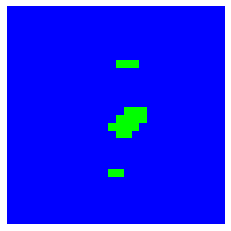

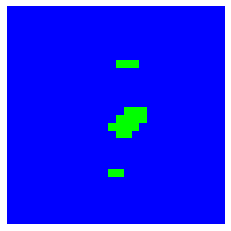

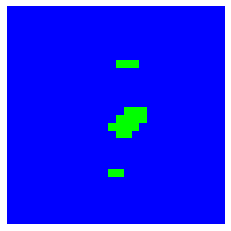

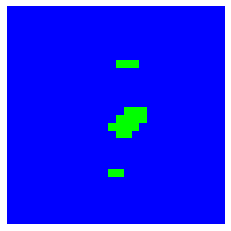

In [35]:
# Passing 4 different test image inputs and visualizing state output
output = MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv[0:4], weights, 3, True)

As we can see that, we used 4 different test set inputs, and passed it through network evolution. <br>
After evolution every different test is becoming to same state. <br>
This can be because images are highly correleated. [REF](https://iopscience.iop.org/article/10.1088/1757-899X/862/5/052048/pdf) <br>
I will be using techniques used in above research paper to improve upon the existing model's working

Above research paper discusses that images are highly correleated, so they performed Deskewing and cropping operation as part of preprocessing. It also updated weight matrix by using Storkley method(wont be implementing this). <br>

In [36]:
# SOURCE: https://stackoverflow.com/questions/43577665/deskew-mnist-images , https://fsix.github.io/mnist/Deskewing.html
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


Will now update the preprocessing function to deskew and crop images. <br>
Images are being cropped to be 14x14 pixels because it gives good results and eliminates redundant data(Optimal value discussed in research paper referenced below). Other values like thresholding for training set and test set used below are also the ones explored in research paper. 


In [37]:
def preprocessing_image_deskew_crop(training_images, threshold=127, pattern_size = 28):

    training_conv = np.zeros((len(training_images),14,14))
    for i in range(len(training_images)):

        temp_img = deskew(training_images[i])

        temp_img=temp_img[7:21,7:21]

        img_boolean = (temp_img>=threshold) # This will return array of true and false

        # converting boolean to int
        img_int = img_boolean.astype(int) # https://stackoverflow.com/questions/17506163/how-to-convert-a-boolean-array-to-an-int-array
        img_int[img_int == 0] = -1 # Setting 0's to -1

        training_conv[i,:,:] = img_int

    return training_conv


Training all images is time intensive and Hopfield networks dont have that much storage capacity too. So for that, I will be training only few instance of digits instead of all

In [38]:
def generate_small_training_list(training_images, training_label,instance_per_digit=2):
    modified_training_images = []
    modified_training_labels = []
    for i in range(10):
        idx = np.random.choice(np.argwhere(training_label==i).flatten(),size=instance_per_digit)
        modified_training_images.extend(training_images[idx,:,:])
        modified_training_labels.extend(training_label[idx])
    return np.array(modified_training_images), np.array(modified_training_labels)

In [39]:
# Getting only 7 inputs per digit for training
small_training_images, small_training_labels = generate_small_training_list(training_images, training_label,7)

In [40]:
# Performing thresholding, deskewing, cropping on both training and test set
# threshold value for training is set 86 and test is 38
# these values were optimal and discussed in reserach paper
small_training_conv = preprocessing_image_deskew_crop(small_training_images, threshold=86) 
test_conv = preprocessing_image_deskew_crop(test_images, threshold=38)


In [41]:
weights = calculate_weights_vectorized(small_training_conv, 14)

In [42]:
output = MNIST_network_evolution(small_training_conv, small_training_labels, test_conv, weights, 1,False)

Checking out the accuracy and F1 score

In [43]:
print("Accuracy is ",accuracy_score(test_label, output))
print("F1 Score is ",f1_score(test_label, output,average="weighted"))

Accuracy is  0.549
F1 Score is  0.529436533288363


Comparison:
We can see that normally without cropping and deskewing process, our model was only outputing 1 label in output. <br>
But after the deskewing and cropping, and using less training images, I was able to get better accuracy. <br>
It took lots of hits and trials and parameter tuning and taking help of research paper to get good parameters to get a accuracy of around 50-60% and F1 score of 0.56.<br>
Comparing to classical algorithm, this is very poor, since this required lots of preprocessing and lots of praying that certain parameters give good outcome, whereas classical algorithms are very efficient, [classical algo](https://github.com/ksopyla/svm_mnist_digit_classification). Here classical algorithms like random forest and SVM are getting 90% + accuracy.<br>
Deep learning algorithms on other hand are getting accuracy of 99% +. <br>



Merits: 
- Hopfield network is a very simple unsupervised learning algorithm, and was performing well in the patterns example when informativeness of cue wasnt bad and pattern size was high
- Hopfield is easy to implement and can behave as a few shot learning algorithm given that data is suitable.
- Vectorized implementation of Hopfield is very fast.

Demerits:
- Hopfield network has pretty limited capacity and cant be used to train lots of patterns.
- Hopfield network is a very basic model and would work better with advancements and improvements as we saw that it performed poorly on MNIST dataset.
- Hopfield network can get to local minima state instead of global minima [REF](https://www.skedsoft.com/books/neural-network-fuzzy-systems/limitations-to-using-the-hopfield-network)
- If patterns are somewhat similar, model will behave poorly
- Weights are symmetric making weights store only half the information at the space it uses.
- Weights being symmetrical is not biologically plausible


Acknowledgments and Reference:
- [Research Paper](https://iopscience.iop.org/article/10.1088/1757-899X/862/5/052048) was helpful in the process for increasing accuracy of the code
- My peers Sharanya Saha and Debdeep Paul Chaudhuri were helpful for discussing about the assignment problems and thinking how to make our models better.
- [Reference slides](https://www.doc.ic.ac.uk/~ae/papers/Hopfield-networks-15.pdf)
- [Demerits](https://www.skedsoft.com/books/neural-network-fuzzy-systems/limitations-to-using-the-hopfield-network)